1- Considere uma cadeia circular composta por  átomos, cada um de massa , conectados por molas idênticas de constante elástica . O sistema está sujeito a condições de contorno ou seja a primeira massa está ligada a última massa. Em uma das simulações, introduza um defeito de massa:  substitua uma massa m2 (m2=5m)
 
Parâmetros
• Massas padrão:  m=1 kg
 • Constante elástica: k = 1 N/m
 • Tamanhos da cadeia: N = 100, 1000 e 10.000
• Defeito: massa igual a m2 = 5kg  (apenas em uma das simulações)
 
Tarefas
1. Cálculo das Frequências de Vibração
• Para cada valor de  (100, 1000, 10000), calcule as frequências naturais de vibração do sistema para:
• Cadeia homogênea (todas as massas iguais)
• Cadeia com defeito de massa no centro
2. Densidade de Estados
• Construa histogramas (densidade de estados) para os valores de  obtidos em cada caso.
• Compare os histogramas para diferentes tamanhos de cadeia e para a presença/ausência do defeito.
3. Deslocamentos Relativos (Modos Normais)
• Para cada cadeia, obtenha os vetores de deslocamento (modos normais) correspondentes:
• Às cinco menores frequências (modos de baixa energia)
• Às cinco maiores frequências (modos de alta energia)
• Apresente gráficos dos deslocamentos relativos dos átomos para esses modos.
4. Análise e Comparação
• Analise como o tamanho da cadeia e a presença do defeito afetam:
• A distribuição das frequências (densidade de estados)
• Os padrões de deslocamento dos modos normais
• Discuta a localização dos modos associados ao defeito de massa.
Orientações para Implementação em Python
• O código deve ser bem documentado e comentado, facilitando o entendimento de cada etapa do processo.
• Utilize bibliotecas como `numpy` e `matplotlib` para cálculos e visualizações.
• Monte a matriz dinâmica do sistema e calcule seus autovalores e autovetores.
• Para grandes valores de , otimize o código para eficiência computacional.
• Disponibilize o código final em um repositório no GitHub e inclua o link no relatório.
 
Instruções para Entrega
 • A resposta deve ser enviada via Moodle devidamente comentada.
• Inclua todos os gráficos gerados (histogramas, modos normais, etc.) no arquivo de resposta, pois não será possível rodar todos os programas novamente para correção.
• Certifique-se de que cada gráfico esteja devidamente identificado e relacionado ao caso analisado.
 
Sugestão de Estrutura para a resposta
1. Introdução
• Breve explicação do modelo massa-mola e sua relevância para cadeias atômicas.
2. Metodologia
• Descrição do método numérico utilizado para calcular frequências e modos.
3. Resultados
• Histogramas das densidades de estados para cada caso.
• Gráficos dos deslocamentos relativos para os modos selecionados.
• Tabela comparativa dos principais resultados.
4. Discussão
• Interpretação dos efeitos do tamanho da cadeia e do defeito de massa.
• Observações sobre a localização dos modos e possíveis aplicações.
5. Conclusão
• Síntese dos principais achados.
Observação: Comente o código de forma clara, disponibilize o link do GitHub e anexe todos os gráficos no Moodle para garantir a avaliação completa.
Texto de resposta Questão 1



















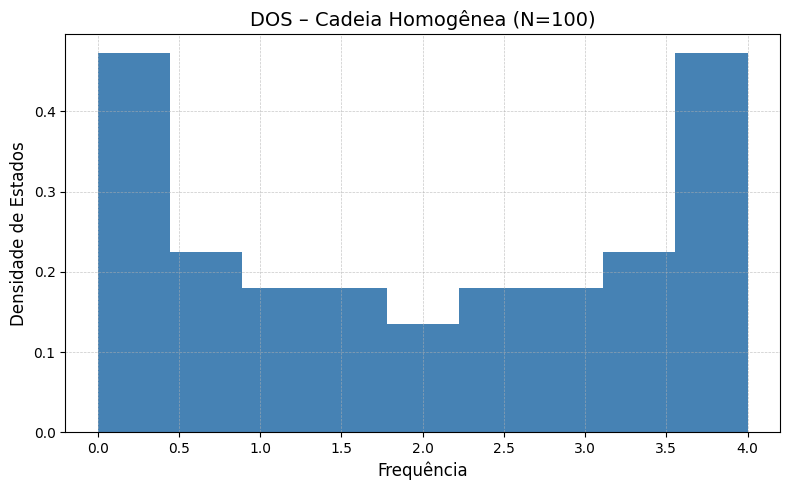

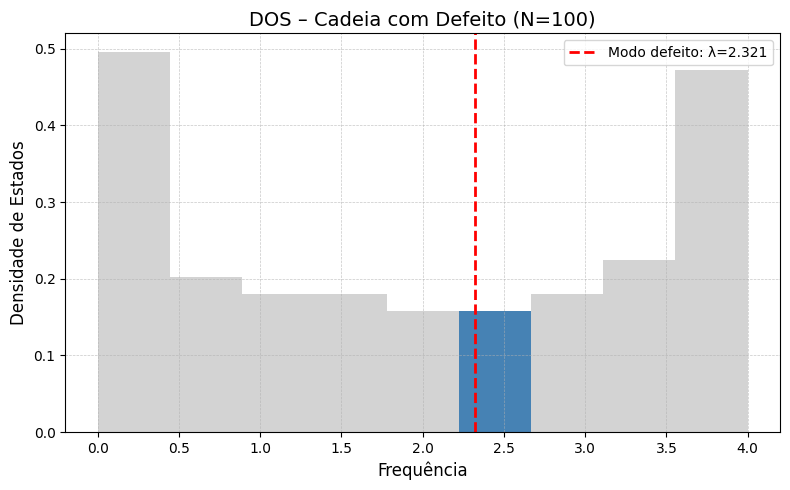

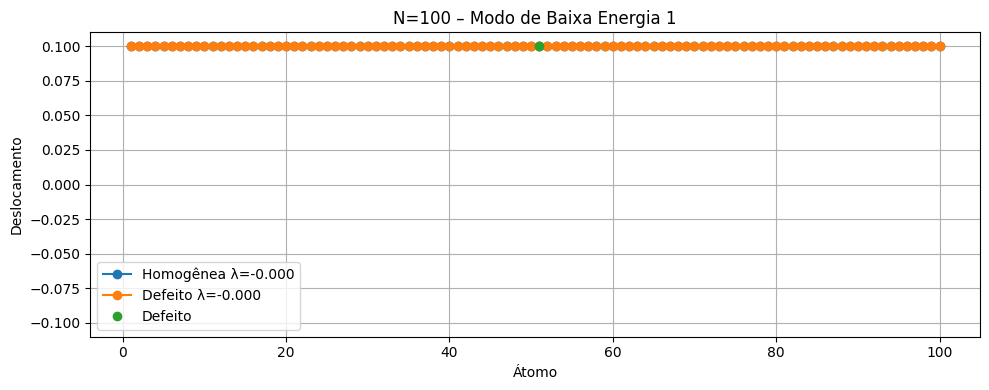

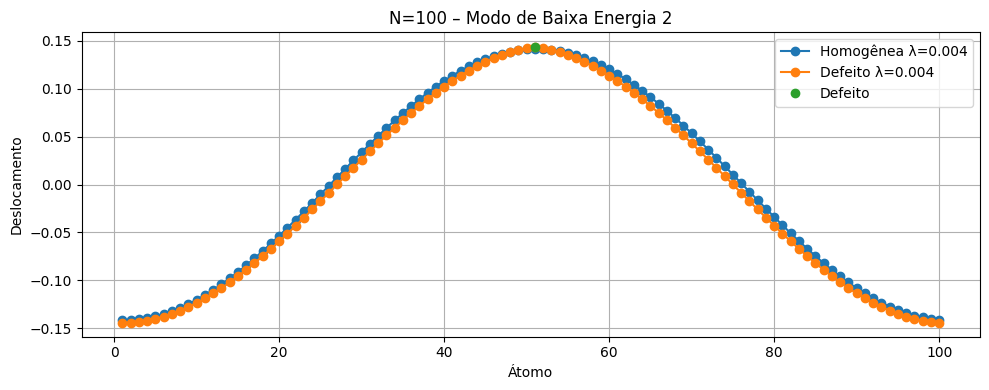

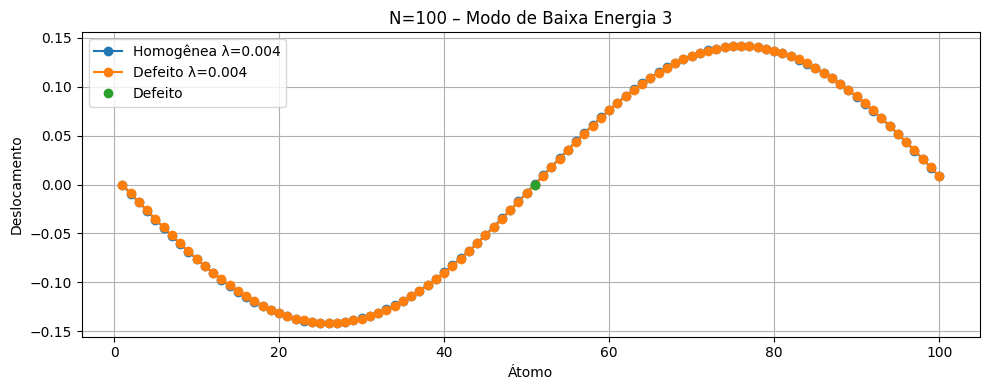

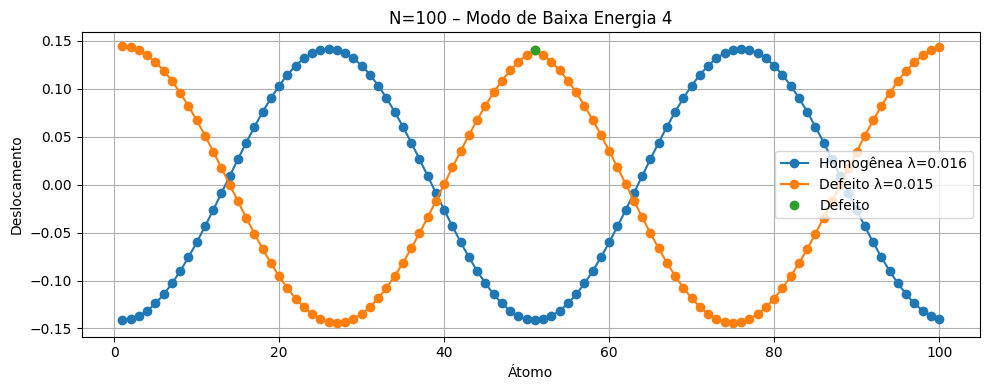

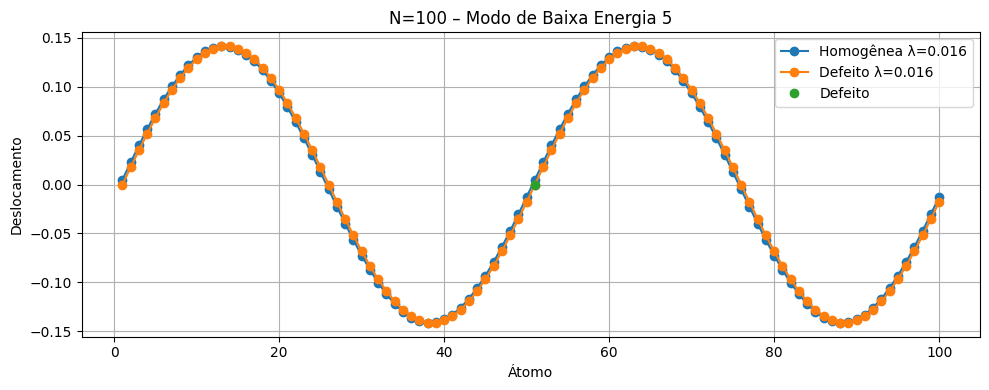

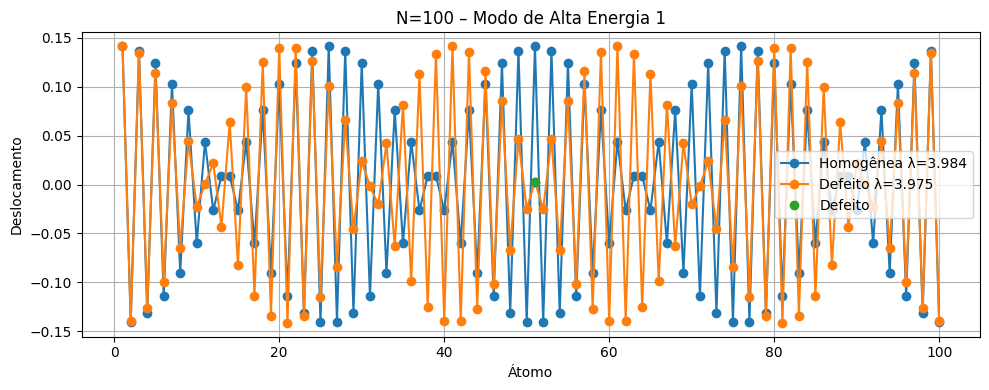

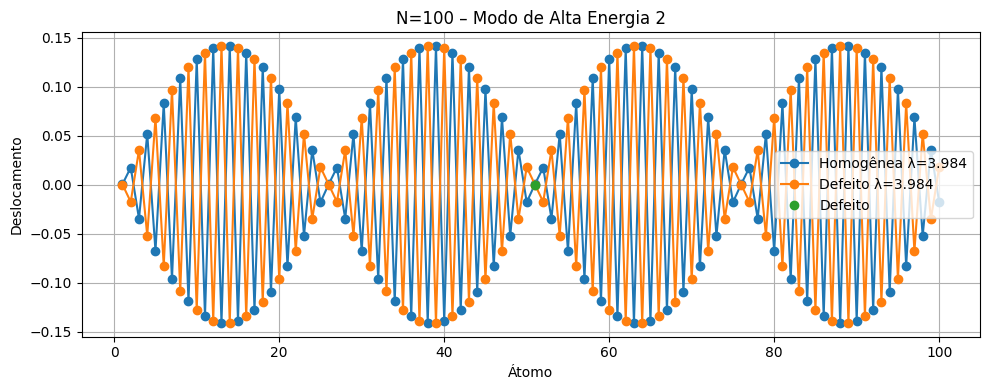

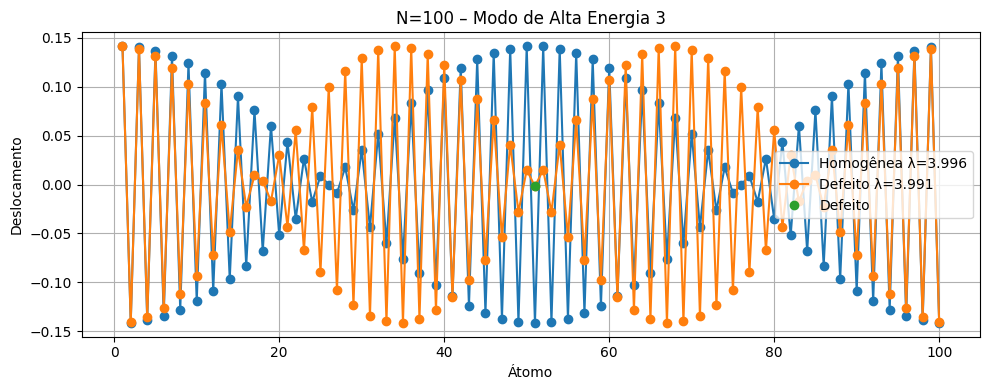

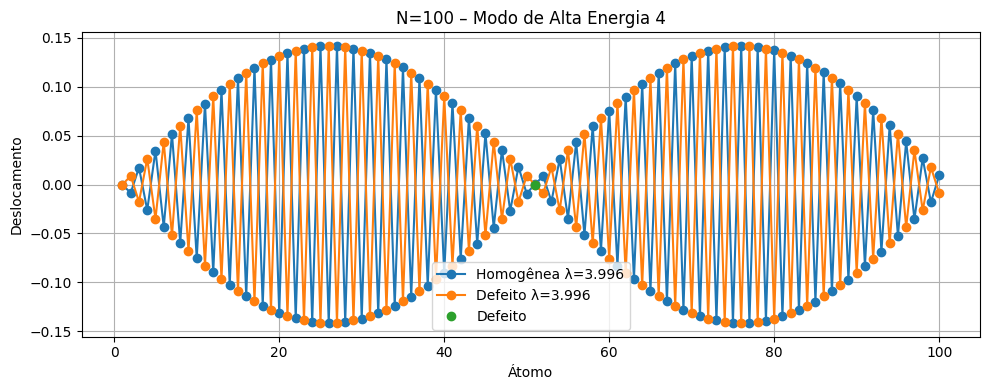

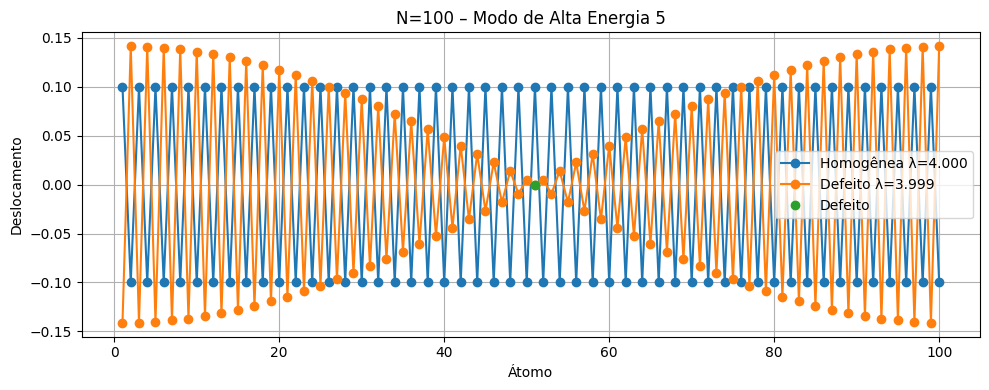

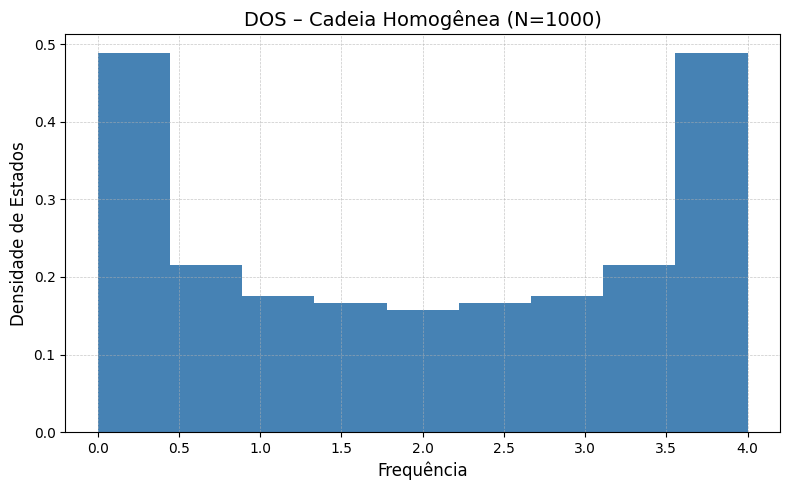

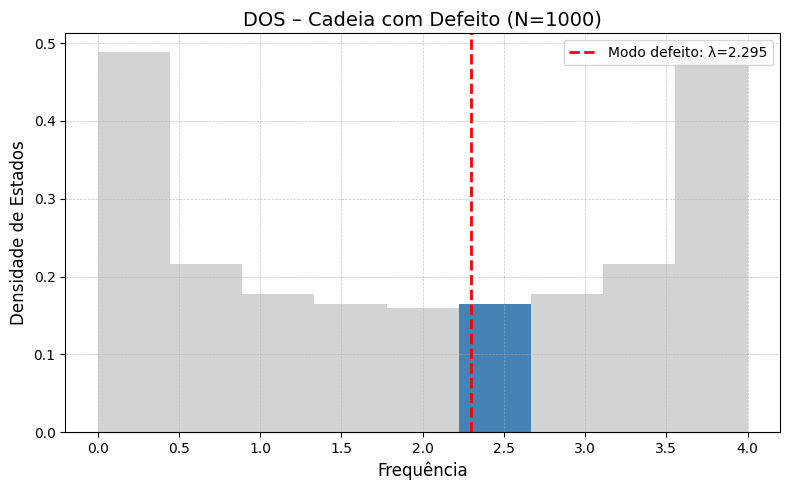

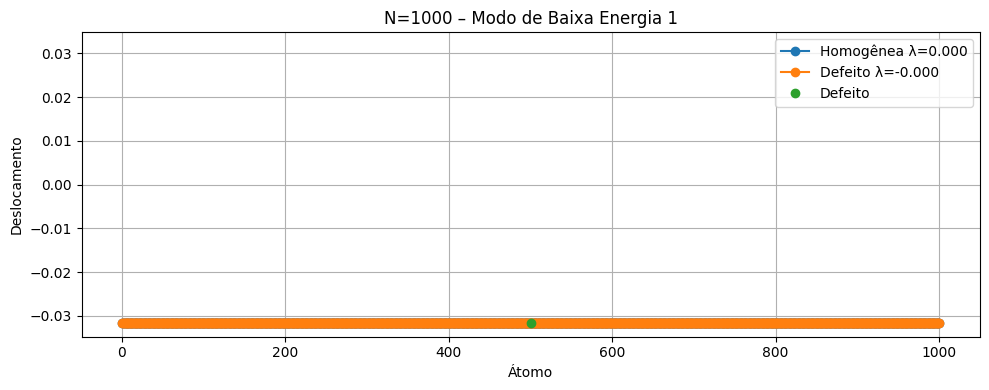

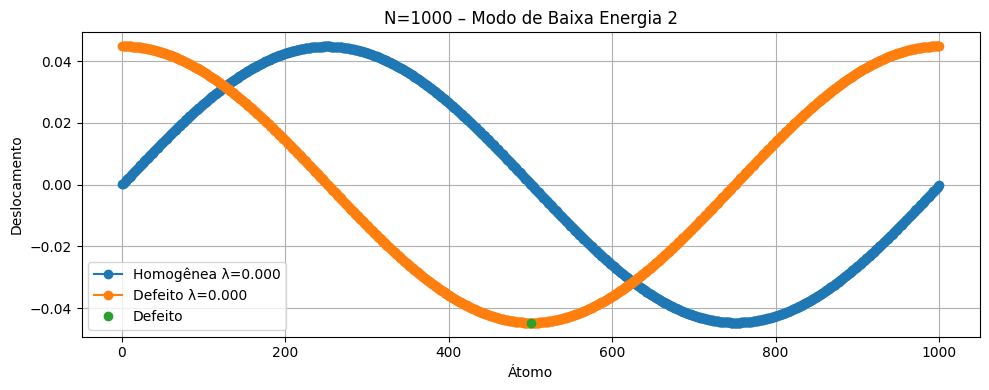

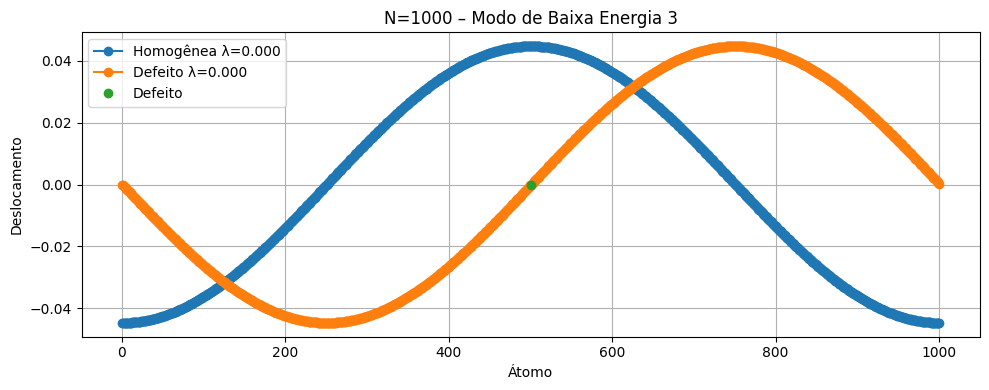

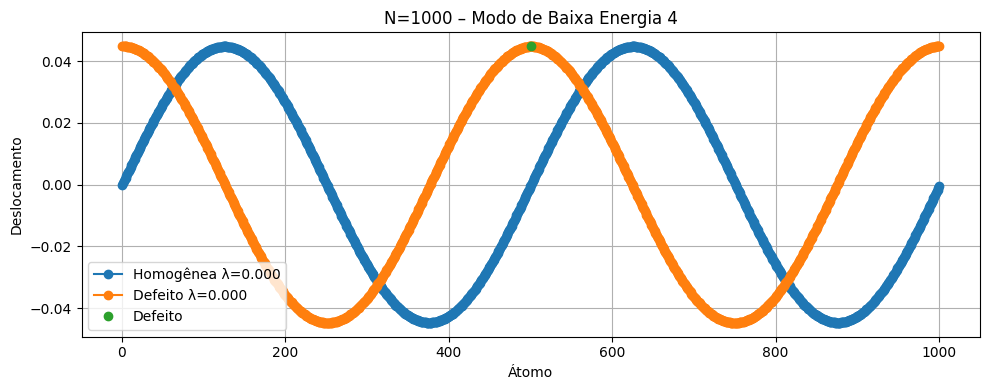

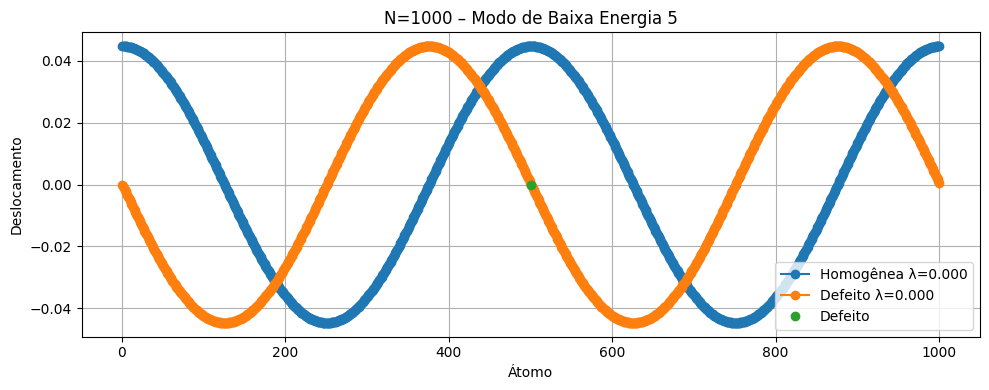

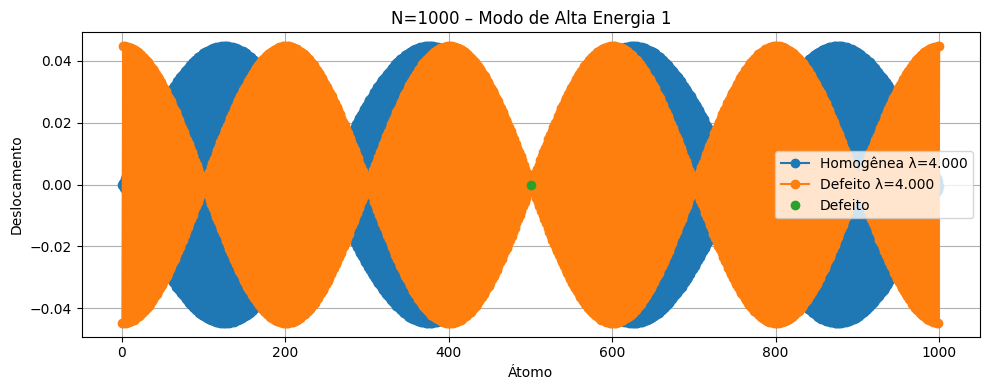

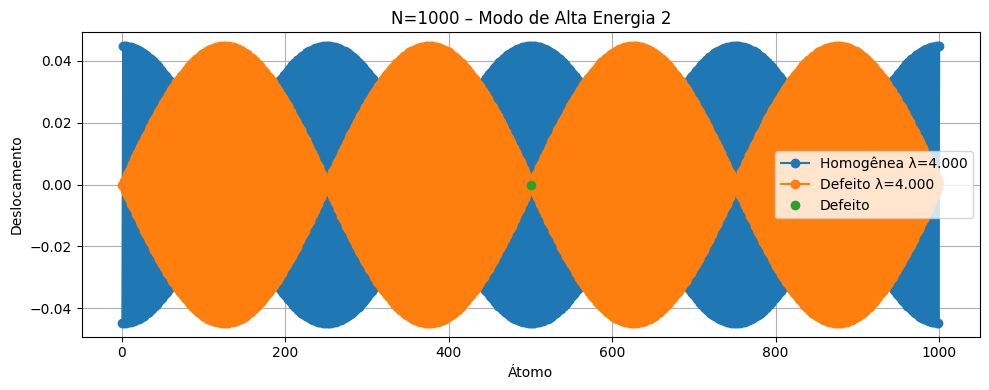

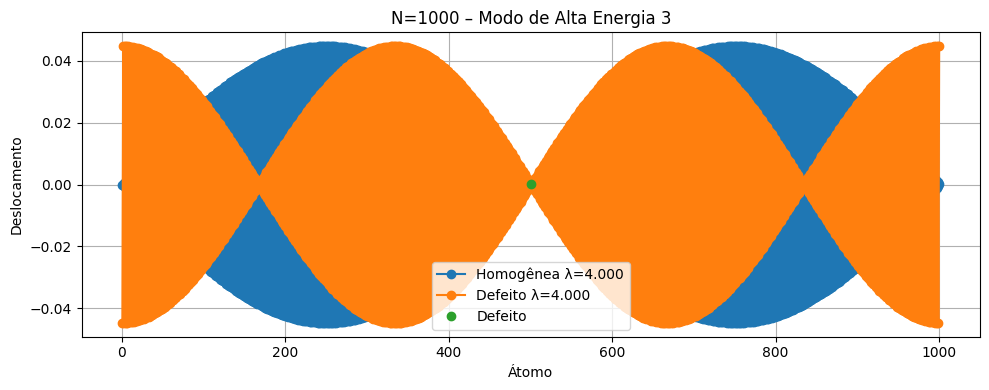

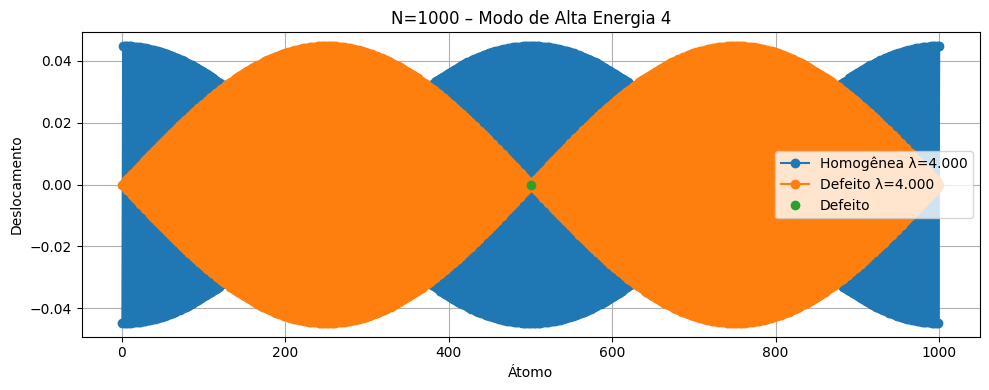

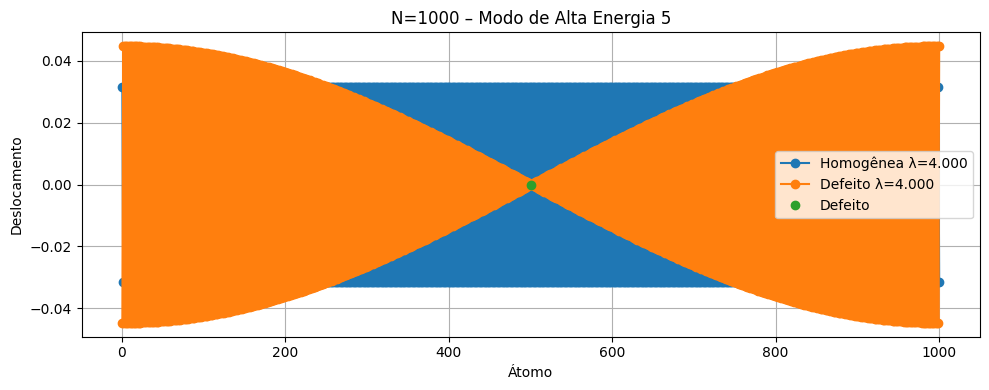

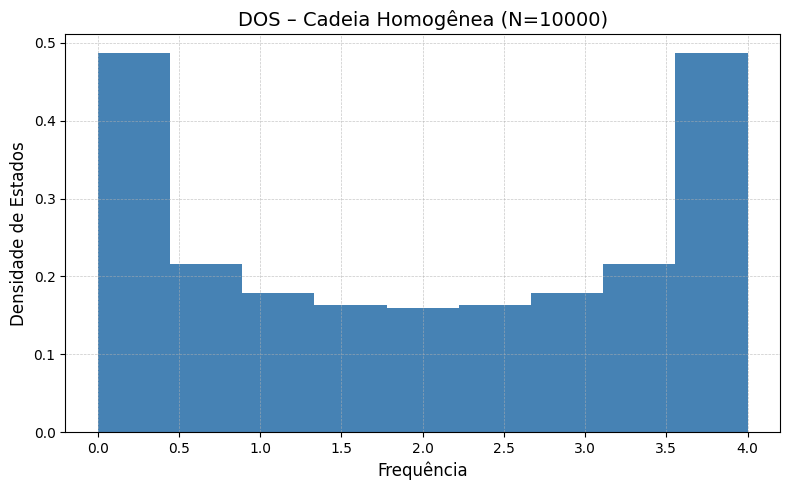

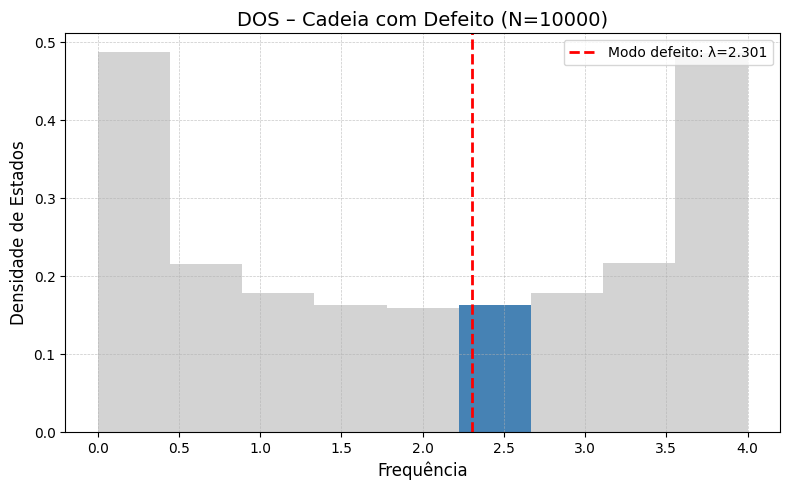

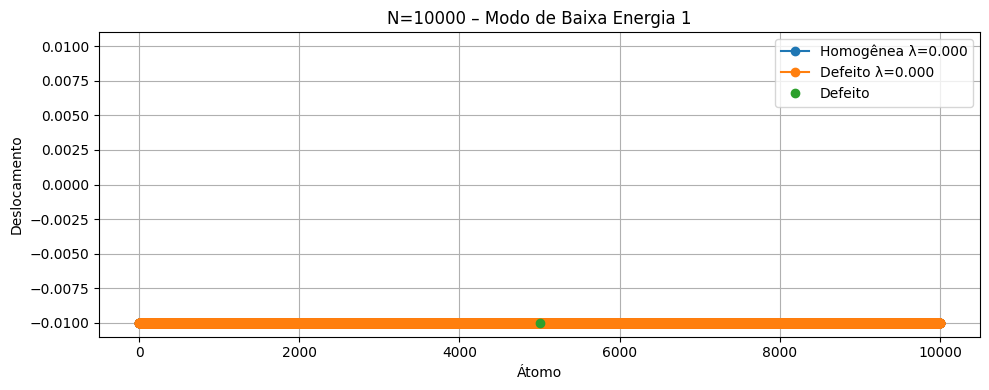

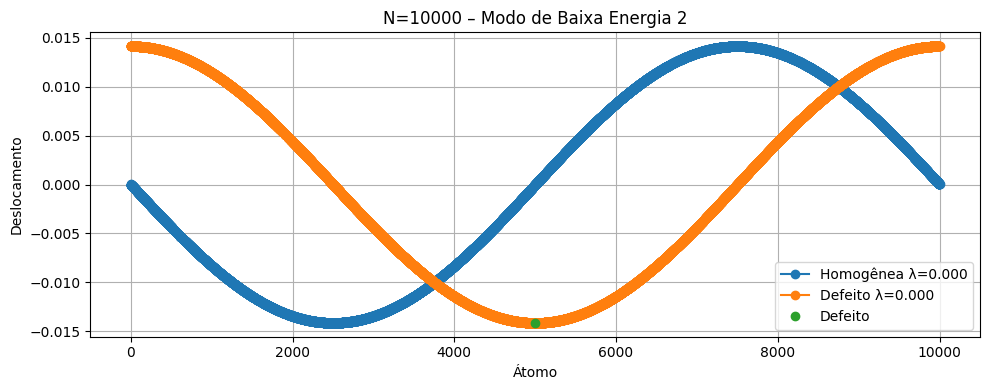

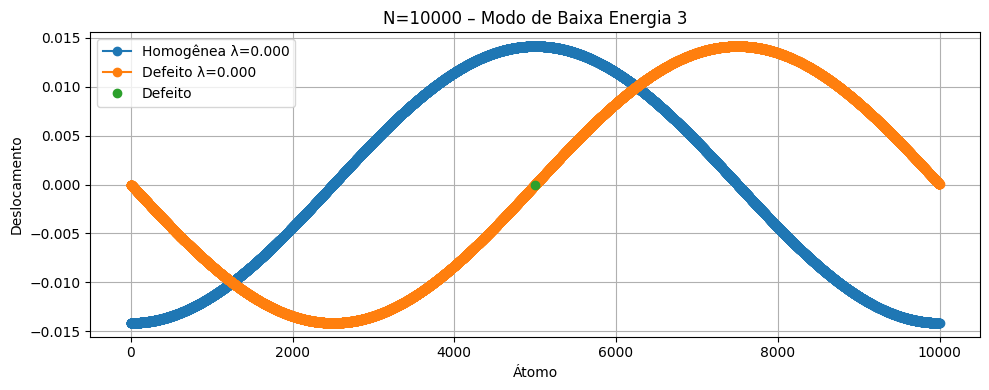

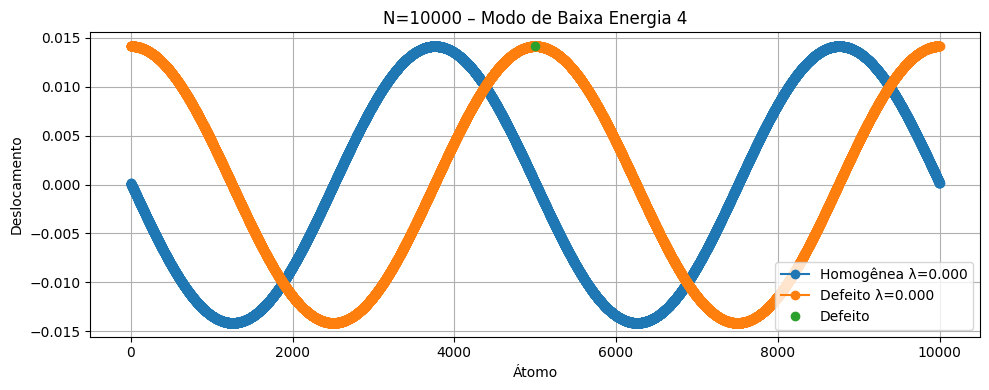

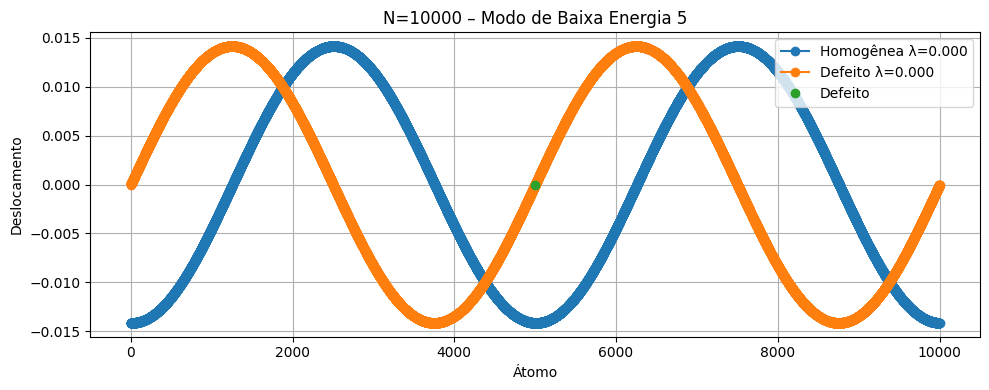

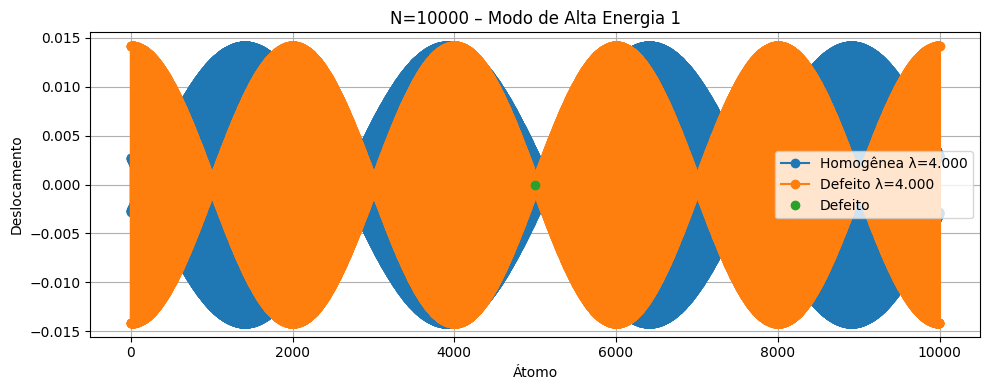

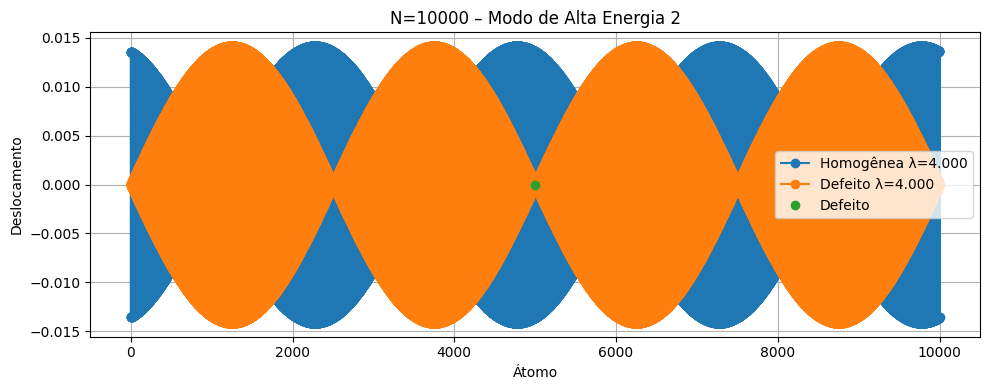

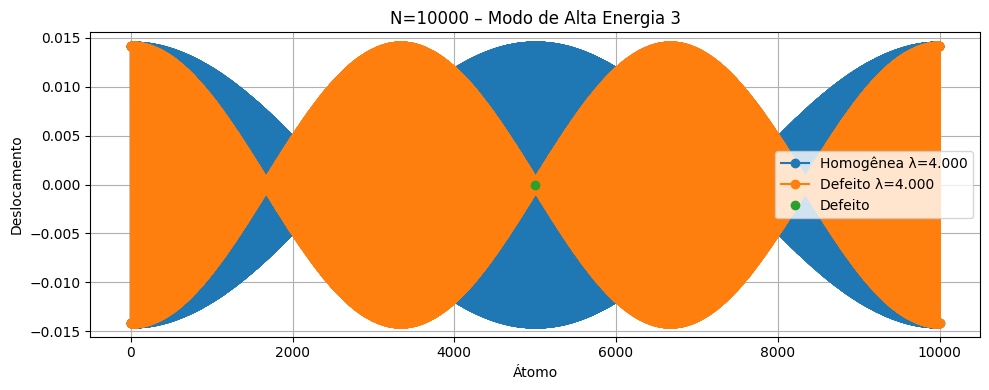

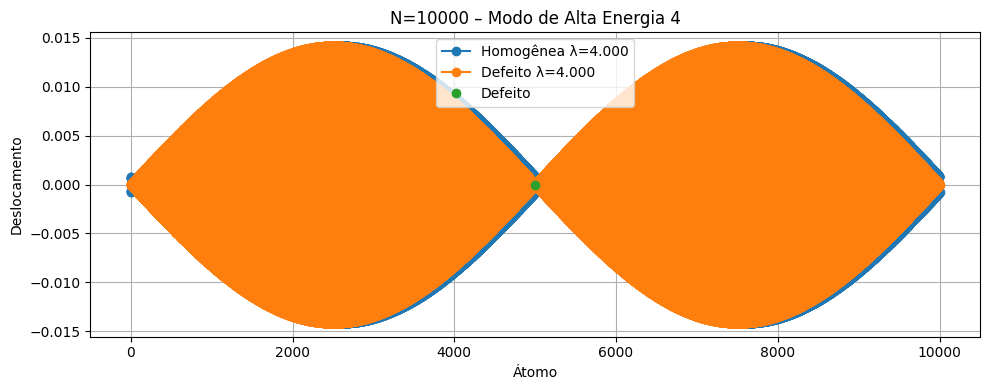

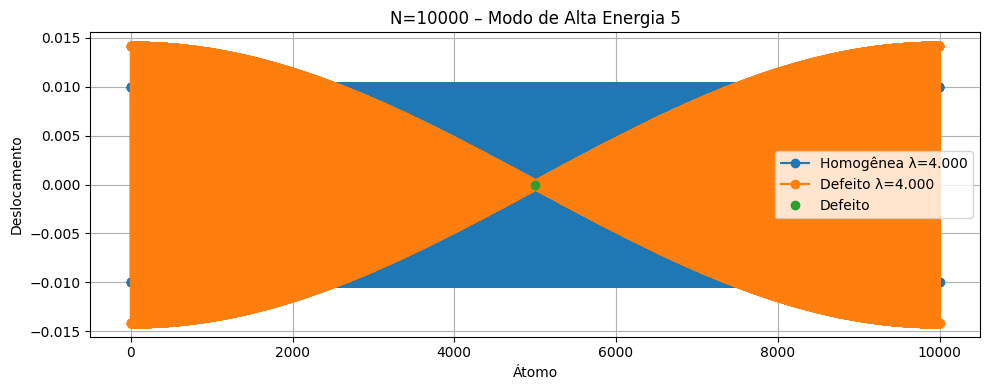

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def montar_matrizes(N, m=1.0, k=1.0, defeito=False, m2=5.0):
    vet_masas = np.ones(N) * m
    if defeito:
        vet_masas[N // 2] = m2
    K = np.zeros((N, N))
    np.fill_diagonal(K, 2 * k)
    for i in range(N - 1):
        K[i, i+1] = -k
        K[i+1, i] = -k
    # condições de contorno periódicas
    K[0, N-1] = -k
    K[N-1, 0] = -k
    return vet_masas, K

def calc_eigens(N, defeito=False, m=1.0, k=1.0, m2=5.0):
    vet_masas, K = montar_matrizes(N, m=m, k=k, defeito=defeito, m2=m2)
    M_inv = np.diag(1.0 / vet_masas)
    A = M_inv.dot(K)
    vals, vecs = np.linalg.eig(A)
    vals = np.real(vals)
    idx = np.argsort(vals)
    return vals[idx], vecs[:, idx]

def plot_dos(eig_vals, lam_def=None, title='DOS', bins=9):
    hist, bin_edges = np.histogram(eig_vals, bins=bins, density=True)
    bin_w = bin_edges[1] - bin_edges[0]
    if lam_def is None:
        plt.figure(figsize=(8, 5), dpi=100)
        plt.hist(eig_vals, bins=bins, density=True,
                 color='steelblue', linewidth=0.5)
    else:
        colors = [
            'steelblue' if (bin_edges[i] <= lam_def < bin_edges[i+1]) else 'lightgrey'
            for i in range(len(hist))
        ]
        plt.figure(figsize=(8, 5), dpi=100)
        plt.bar(bin_edges[:-1], hist, width=bin_w, align='edge',
                color=colors, linewidth=0.5)
        plt.axvline(lam_def, color='red', linestyle='--', linewidth=2,
                    label=f'Modo defeito: λ={lam_def:.3f}')
        plt.legend(fontsize=10)
    plt.title(title, fontsize=14)
    plt.xlabel('Frequência', fontsize=12)
    plt.ylabel('Densidade de Estados', fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_comparacao(N, modos=5):
    eig_hom_vals, eig_hom_vecs = calc_eigens(N, defeito=False)
    eig_def_vals, eig_def_vecs = calc_eigens(N, defeito=True)
    x = np.arange(1, N+1)

    # modos de baixa energia
    for i in range(modos):
        plt.figure(figsize=(10, 4))
        plt.plot(x, eig_hom_vecs[:, i], 'o-',
                 label=f'Homogênea λ={eig_hom_vals[i]:.3f}')
        plt.plot(x, eig_def_vecs[:, i], 'o-',
                 label=f'Defeito λ={eig_def_vals[i]:.3f}')
        plt.plot(x[N//2], eig_def_vecs[N//2, i], 'o', label='Defeito')

        # **escala simétrica** usando o maior valor absoluto + 10% de folga
        y_hom = eig_hom_vecs[:, i]
        y_def = eig_def_vecs[:, i]
        max_amp = max(np.abs(y_hom).max(), np.abs(y_def).max())
        pad = 0.1 * max_amp if max_amp > 0 else 0.1
        plt.ylim(-max_amp - pad, +max_amp + pad)

        plt.title(f'N={N} – Modo de Baixa Energia {i+1}')
        plt.xlabel('Átomo')
        plt.ylabel('Deslocamento')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # modos de alta energia
    for j, i in enumerate(range(-modos, 0), start=1):
        plt.figure(figsize=(10, 4))
        plt.plot(x, eig_hom_vecs[:, i], 'o-',
                 label=f'Homogênea λ={eig_hom_vals[i]:.3f}')
        plt.plot(x, eig_def_vecs[:, i], 'o-',
                 label=f'Defeito λ={eig_def_vals[i]:.3f}')
        plt.plot(x[N//2], eig_def_vecs[N//2, i], 'o', label='Defeito')

        # mesma lógica de escala simétrica
        y_hom = eig_hom_vecs[:, i]
        y_def = eig_def_vecs[:, i]
        max_amp = max(np.abs(y_hom).max(), np.abs(y_def).max())
        pad = 0.1 * max_amp if max_amp > 0 else 0.1
        plt.ylim(-max_amp - pad, +max_amp + pad)

        plt.title(f'N={N} – Modo de Alta Energia {j}')
        plt.xlabel('Átomo')
        plt.ylabel('Deslocamento')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# parâmetros
Ns = [100,1000,10000]     
bins = 9
modes_to_plot = 5

for N in Ns:
    eig_hom_vals, _ = calc_eigens(N, defeito=False)
    eig_def_vals, _ = calc_eigens(N, defeito=True)

    # identifica modo de defeito
    dist = np.min(np.abs(eig_def_vals[:, None] - eig_hom_vals), axis=1)
    idx_def = np.argmax(dist)
    lam_def = eig_def_vals[idx_def]

    # plota DOS
    plot_dos(eig_hom_vals,
             title=f'DOS – Cadeia Homogênea (N={N})',
             bins=bins)
    plot_dos(eig_def_vals, lam_def=lam_def,
             title=f'DOS – Cadeia com Defeito (N={N})',
             bins=bins)

    # plota comparação de modos
    plot_comparacao(N, modos=modes_to_plot)

